# 3 Unsupervised Learning
Student ID: 35224436 | Full name: Yiming Zhang

## Question 3 Self-supervised Neural Network Learning

### Task I

#### Import Packages

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

#### Load Datasets

In [107]:
# Load datasets
# Task2C_labeled.csv - for training classifiers
labeled_data = pd.read_csv("Dataset_S2_2025/Task2C_labeled.csv")

# Task2C_unlabeled.csv - for training autoencoder (unlabeled data)
unlabeled_data = pd.read_csv("Dataset_S2_2025/Task2C_unlabeled.csv")

# Task2C_test.csv - for evaluating the trained classifier
test_data = pd.read_csv("Dataset_S2_2025/Task2C_test.csv")

# Display basic dataset information
print("===== Labeled Dataset (Task2C_labeled.csv) Information: =====")
print(f"Shape: {labeled_data.shape}")
print(f"Number of features: {labeled_data.shape[1] - 1} (pixel features)")
print(f"Number of samples: {labeled_data.shape[0]}")

print("\n===== Unlabeled Dataset (Task2C_unlabeled.csv) Information: =====")
print(f"Shape: {unlabeled_data.shape}")
print(f"Number of features: {unlabeled_data.shape[1]} (pixel features)")
print(f"Number of samples: {unlabeled_data.shape[0]}")

print("\n===== Test Dataset (Task2C_test.csv) Information: =====")
print(f"Shape: {test_data.shape}")
print(f"Number of features: {test_data.shape[1]} (pixel features)")
print(f"Number of samples: {test_data.shape[0]}")

===== Labeled Dataset (Task2C_labeled.csv) Information: =====
Shape: (50, 785)
Number of features: 784 (pixel features)
Number of samples: 50

===== Unlabeled Dataset (Task2C_unlabeled.csv) Information: =====
Shape: (1500, 784)
Number of features: 784 (pixel features)
Number of samples: 1500

===== Test Dataset (Task2C_test.csv) Information: =====
Shape: (500, 785)
Number of features: 785 (pixel features)
Number of samples: 500


### Task II

#### Data Preparation

In [108]:
# Prepare data for autoencoder training
# Combine labeled and unlabeled data (use only features, not labels)
# For labeled data, drop the 'label' column
X_labeled = labeled_data.drop('label', axis=1).values
X_unlabeled = unlabeled_data.values

# Combine both datasets for autoencoder training
X_autoencoder = np.vstack([X_labeled, X_unlabeled])

print(f"Combined data for autoencoder training:")
print(f"  - Labeled samples (features only): {X_labeled.shape}")
print(f"  - Unlabeled samples: {X_unlabeled.shape}")
print(f"  - Total samples for autoencoder: {X_autoencoder.shape}")
print(f"  - Number of input features: {X_autoencoder.shape[1]}")


Combined data for autoencoder training:
  - Labeled samples (features only): (50, 784)
  - Unlabeled samples: (1500, 784)
  - Total samples for autoencoder: (1550, 784)
  - Number of input features: 784


#### Helper Functions

In [109]:
# Define helper functions for autoencoder
def normalize(x, m=None, s=None):
    if m is None or s is None:
        # print('Normalizing data: No mean and/or sd given. Assuming it is training data')
        m, s = x.mean(), x.std()

    return (x - m) / s


def get_dataloader(X_train,Y_train=None, autoencoder=False,bs=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case autoencoder=True, Y_train automatically is set to X_train
    The function returns the dataloader only if return_dataset is False otherwise it returns a tuple (dataloader,train_dataset)
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train= np.array(X_train).astype(np.float32)
        if standardize: X_train = normalize(X_train)
        if not autoencoder: Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Make sure your input and labels are array-likes. Your input failed with exception: %s'%e)
    # transform into tensors
    if autoencoder:
        Y_train = X_train
    
    X_train, Y_train = map(tensor, (X_train, Y_train))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
            
    train_ds = TensorDataset(X_train,Y_train)
    train_dl = DataLoader(train_ds, batch_size=16)
    
    if return_dataset: return train_dl,train_ds
    
    return train_dl



def train_autoencoder(X_train,hidden,activation='Tanh',epochs=10, trace=True, device="cpu", **kwargs):
    """
    Trains an Autoencoder and returns the trained model
    
    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    
    **kwargs: passed to Adam optimizer, lookup adam optimizer for more details
    """
    train_dl = get_dataloader(X_train,autoencoder=True)
    
    device = device
    
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = n_inps
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses = []
    # define optimizer with learning rate
    optimizer = optim.Adam(model.parameters(), **kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.MSELoss()
    # print the loss every 10% of epochs
    printing_step = int(epochs/5)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    return model, epoch_losses

In [110]:
# Train autoencoders with different hidden layer sizes
# Hidden layer sizes: 20, 60, 100, 140, 180, 220 (step size 40)

hidden_sizes = list(range(20, 221, 40))  # [20, 60, 100, 140, 180, 220]
print(f"Training autoencoders with hidden layer sizes: {hidden_sizes}\n")

# Training parameters
epochs = 50
lr = 0.001
activation = 'Tanh'

# Store models and losses
autoencoder_models = {}
autoencoder_losses = {}

# Train each autoencoder
for hidden_size in hidden_sizes:
    print(f"\n{'='*60}")
    print(f"Training autoencoder with {hidden_size} hidden neurons")
    print(f"{'='*60}")
    
    model, losses = train_autoencoder(
        X_train=X_autoencoder,
        hidden=[hidden_size],
        activation=activation,
        epochs=epochs,
        lr=lr,
        trace=True
    )
    
    autoencoder_models[hidden_size] = model
    autoencoder_losses[hidden_size] = losses
    
    print(f"Final loss for {hidden_size} neurons: {losses[-1]:.6f}")

print(f"\n{'='*60}")
print(f"Training completed for all autoencoders!")
print(f"{'='*60}")


Training autoencoders with hidden layer sizes: [20, 60, 100, 140, 180, 220]


Training autoencoder with 20 hidden neurons
Training Model on cpu
Epoch 0 out of 50. Loss:0.7917865520900058
Epoch 10 out of 50. Loss:0.3489048806662412
Epoch 20 out of 50. Loss:0.2853835791963892
Epoch 30 out of 50. Loss:0.2747317067126638
Epoch 40 out of 50. Loss:0.2598228141204598
Final loss for 20 neurons: 0.257776

Training autoencoder with 60 hidden neurons
Training Model on cpu
Epoch 0 out of 50. Loss:0.6389094634154409
Epoch 10 out of 50. Loss:0.17091536491187578
Epoch 20 out of 50. Loss:0.14539073161857644
Epoch 30 out of 50. Loss:0.12396658434695804
Epoch 40 out of 50. Loss:0.12411482808823437
Final loss for 60 neurons: 0.119277

Training autoencoder with 100 hidden neurons
Training Model on cpu
Epoch 0 out of 50. Loss:0.5573830171344206
Epoch 10 out of 50. Loss:0.11791545928446288
Epoch 20 out of 50. Loss:0.09146461758724193
Epoch 30 out of 50. Loss:0.09183375114939876
Epoch 40 out of 50. Loss:0.07

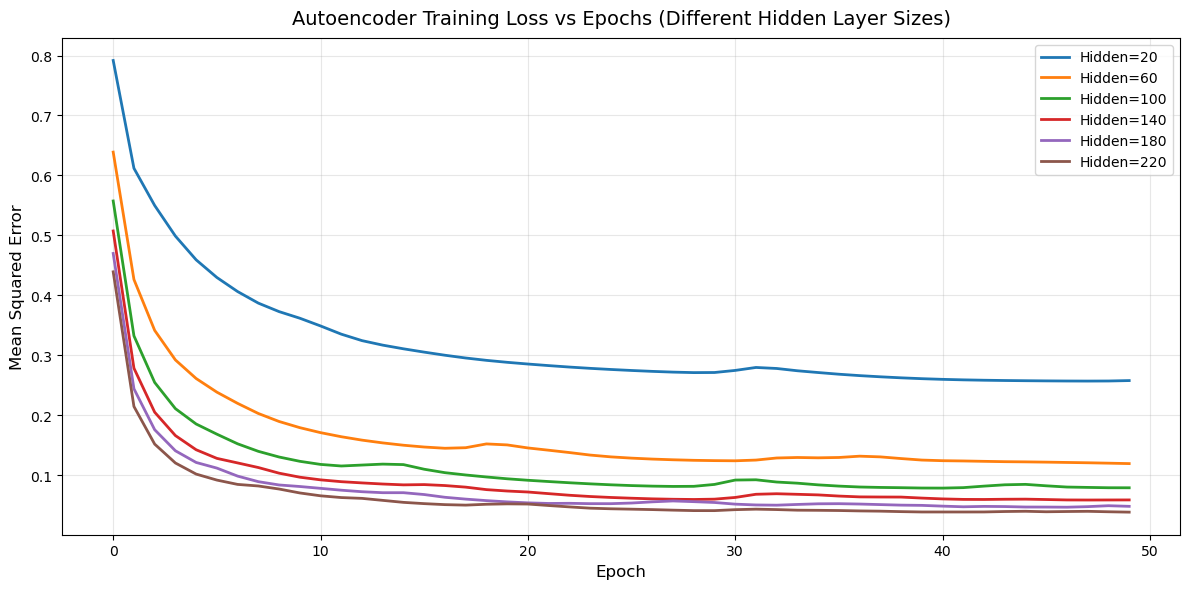


Final MSE Loss for each autoencoder:
----------------------------------------
  20 neurons: 0.257776
  60 neurons: 0.119277
  100 neurons: 0.078920
  140 neurons: 0.058673
  180 neurons: 0.047978
  220 neurons: 0.038297


In [111]:
# Visualize training losses for all autoencoders

plt.figure(figsize=(12, 6))

for hidden_size in hidden_sizes:
    losses = autoencoder_losses[hidden_size]
    plt.plot(range(len(losses)), losses, label=f'Hidden={hidden_size}', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Autoencoder Training Loss vs Epochs (Different Hidden Layer Sizes)', fontsize=14, pad=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display final losses
print("\nFinal MSE Loss for each autoencoder:")
print("-" * 40)
for hidden_size in hidden_sizes:
    final_loss = autoencoder_losses[hidden_size][-1]
    print(f"  {hidden_size} neurons: {final_loss:.6f}")


### Task III

#### Calculate Reconstruction Error

In [ ]:
def calculate_reconstruction_error(model, X_data):
    """
    Calculate the reconstruction error as the average Euclidean distance
    between input and output of the autoencoder
    """
    # Prepare data (normalize it the same way as during training)
    X_normalized = normalize(X_data.astype(np.float32))
    X_tensor = torch.tensor(X_normalized)

    # Move to the same device as model
    device = next(model.parameters()).device
    X_tensor = X_tensor.to(device)

    # Get model predictions (reconstructions)
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        reconstructions = model(X_tensor)

    # Calculate Euclidean distance for each sample
    euclidean_distances = torch.sqrt(
        torch.sum((X_tensor - reconstructions) ** 2, dim=1)
    )

    # Calculate average reconstruction error
    avg_error = euclidean_distances.mean().item()

    return avg_error

In [113]:
# Calculate reconstruction error for each autoencoder model
reconstruction_errors = {}

print("Calculating reconstruction errors for all autoencoders...\n")
print("=" * 60)

for hidden_size in hidden_sizes:
    model = autoencoder_models[hidden_size]
    error = calculate_reconstruction_error(model, X_autoencoder)
    reconstruction_errors[hidden_size] = error
    print(f"Hidden layer size {hidden_size:3d} neurons: Reconstruction Error = {error:.6f}")

print("=" * 60)
print("\nReconstruction error calculation completed!")


Calculating reconstruction errors for all autoencoders...

Hidden layer size  20 neurons: Reconstruction Error = 14.045708
Hidden layer size  60 neurons: Reconstruction Error = 9.580141
Hidden layer size 100 neurons: Reconstruction Error = 7.803748
Hidden layer size 140 neurons: Reconstruction Error = 6.876702
Hidden layer size 180 neurons: Reconstruction Error = 6.126649
Hidden layer size 220 neurons: Reconstruction Error = 5.718480

Reconstruction error calculation completed!


#### Visualize Reconstruction Error vs Hidden Layer Size


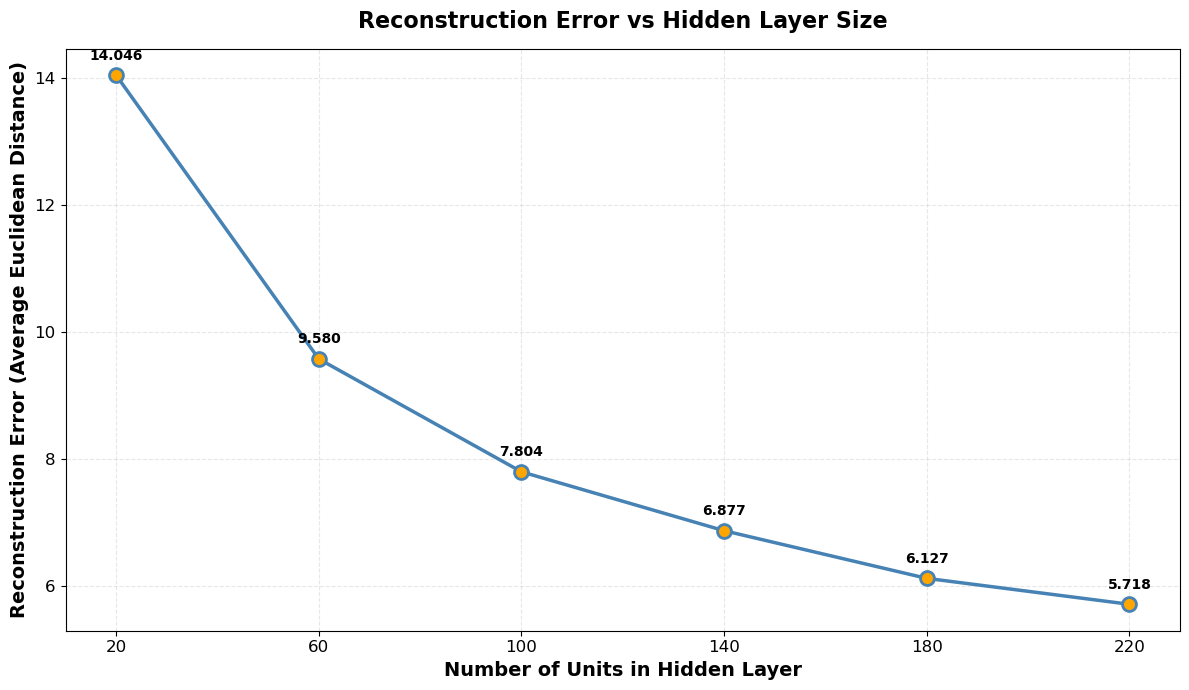

In [114]:
# Plot reconstruction error vs number of hidden neurons
plt.figure(figsize=(12, 7))

# Extract values for plotting
hidden_neurons = list(reconstruction_errors.keys())
errors = list(reconstruction_errors.values())

# Create line plot with markers
plt.plot(hidden_neurons, errors, marker='o', markersize=10, linewidth=2.5, 
         color='steelblue', markerfacecolor='orange', markeredgewidth=2, markeredgecolor='steelblue')

# Add value labels on each point
for i, (neurons, error) in enumerate(zip(hidden_neurons, errors)):
    plt.text(neurons, error + 0.2, f'{error:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
plt.xlabel('Number of Units in Hidden Layer', fontsize=14, fontweight='bold')
plt.ylabel('Reconstruction Error (Average Euclidean Distance)', fontsize=14, fontweight='bold')
plt.title('Reconstruction Error vs Hidden Layer Size', fontsize=16, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(hidden_neurons, fontsize=12)
plt.yticks(fontsize=12)

# Add a subtle background color
ax = plt.gca()

plt.tight_layout()
plt.show()


#### Analysis and Findings

Based on the plot of reconstruction error vs. hidden layer size, we can observe the following key findings:

1. **Inverse Relationship**: There is a clear inverse relationship between the number of hidden neurons and the reconstruction error. As the number of hidden neurons increases, the reconstruction error decreases consistently.

2. **Diminishing Returns**: The rate of improvement (error reduction) follows a pattern of diminishing returns:
   - From 20 to 60 neurons: Large improvement in reconstruction error
   - From 60 to 100 neurons: Moderate improvement
   - From 100 to 220 neurons: Gradual but smaller improvements
   
3. **Capacity and Representation**:
   - **Smaller hidden layers (20 neurons)** create a significant bottleneck, forcing the autoencoder to learn a highly compressed representation. This results in higher reconstruction error as important information is lost in the compression.
   - **Larger hidden layers (220 neurons)** provide more capacity to capture the underlying patterns and structure in the data, resulting in better reconstruction quality.

4. **Trade-off Considerations**:
   - While larger hidden layers yield lower reconstruction error, they also require more computational resources and are more prone to overfitting, which may not generalize as well to unseen data
   - Smaller hidden layers provide better dimensionality reduction but at the cost of reconstruction quality


### Task IV

### Task V

### Task VI